## Mount Drive & Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import imutils
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly.offline import iplot

from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [3]:
#filepath = '/content/drive/My Drive/ML/Data/Handwriting/' #On Drive 
filepath = '/content/drive/My Drive/MSCA_ML/Final_Project/Data/Handwriting/'

### Loading Image

In [4]:
train = pd.read_csv(filepath + 'df_trail_padded.csv', index_col = 0)
test = pd.read_csv(filepath + 'df_trail_padded_test.csv', index_col = 0)

In [5]:
train.shape

(34306, 3841)

In [53]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,3831,3832,3833,3834,3835,3836,3837,3838,3839,IDENTITY
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,lucie
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,emma
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,romain
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,thomas
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,ines


In [52]:
set(train.iloc[0])

{-1, 0, 'lucie'}

kmeans_boundary_list = [[(75, 0), (250, 35)], [(0, 10), (200, 40)], [(0, 0), (200, 40)], [(25, 35), (175, 65)]]

### Prediction Trail

In [7]:
X_train, y_train = train.drop('IDENTITY', axis = 1), train.IDENTITY

In [ ]:
X_train_trail = X_train.iloc[:10000]
y_train_trail = y_train[:10000]

### Random Hyperparameter Grid

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [ ]:
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_trail,y_train_trail)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 121, 142, 163,
                                                         184, 205, 226, 247,
                                                         268, 289, 310, 331,
                                                         352, 373, 394, 415,
                                                         436, 457, 478, 500]},
         

In [ ]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 80,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 457}

In [ ]:
rf_random.best_score_ * 100

66.60993933826497

### Modeling

In [44]:
from sklearn.model_selection import train_test_split
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.33, random_state=1)

In [45]:
X_test, y_test = test.drop('IDENTITY', axis = 1), test.IDENTITY

In [46]:
#fit a Random Forest classifier
rf_best = RandomForestClassifier(
    bootstrap = False,
    max_depth = 80,
    max_features = 'auto',
    min_samples_leaf = 1,
    min_samples_split = 2,
    n_estimators = 457
 )
rf_best.fit(X_train2,y_train2)

RandomForestClassifier(bootstrap=False, max_depth=80, n_estimators=457)

In [47]:
#predict value of label using classifier
pred_valid = rf_best.predict(X_valid)
print("Validation Accuracy: " + str(accuracy_score(y_valid,pred_valid)))

Validation Accuracy: 0.7832346965815741


In [48]:
pred_train = rf_best.predict(X_train2)
print("Train Accuracy: " + str(accuracy_score(y_train2,pred_train)))

Train Accuracy: 0.9997389601914292


In [49]:
#Test Result
pred_test = rf_best.predict(X_test)
print("Train Accuracy: " + str(accuracy_score(y_test,pred_test)))

Train Accuracy: 0.7946943483275664


### ROC Curve

In [ ]:
from yellowbrick.classifier import ROCAUC

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



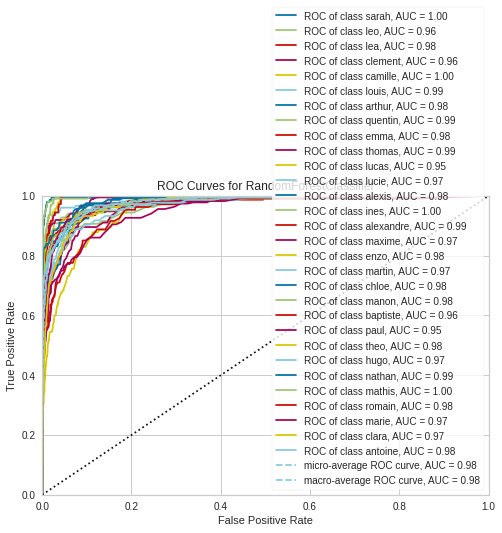

In [ ]:
# Instaniate the classification model and visualizer
#ax = plt.subplot()
visualizer = ROCAUC(rf_best, classes=list(set(y_test)), micro = True)
visualizer.fit(X_train2, y_train2)       
visualizer.score(X_test, y_test)
#visualizer.ax.legend(loc='center left', bbox_to_anchor=(1, 5))
#ax.legend(loc='center left', bbox_to_anchor=(1, 5))
visualizer.show()

In [ ]:
pred_result = pd.DataFrame(pred_test)
pred_result.to_csv(filepath + 'rf_pred_result.csv')

### Confusion Matrix

In [50]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, pred_test)

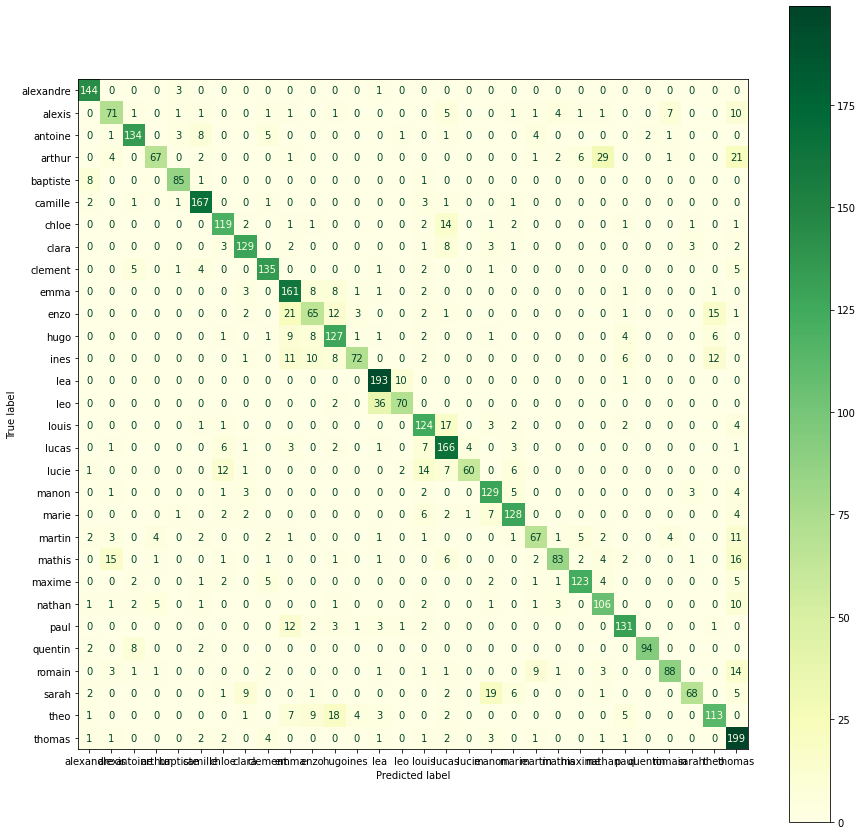

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion,display_labels=rf_best.classes_)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, cmap = 'YlGn')

#### Classification Report

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_test, target_names=rf_best.classes_))

              precision    recall  f1-score   support

   alexandre       0.88      0.97      0.92       148
      alexis       0.70      0.66      0.68       107
     antoine       0.87      0.84      0.85       160
      arthur       0.86      0.50      0.63       134
    baptiste       0.89      0.89      0.89        95
     camille       0.87      0.94      0.91       177
       chloe       0.79      0.82      0.80       145
       clara       0.84      0.85      0.84       152
     clement       0.86      0.88      0.87       154
        emma       0.70      0.87      0.77       186
        enzo       0.62      0.53      0.57       123
        hugo       0.69      0.79      0.74       161
        ines       0.88      0.59      0.71       122
         lea       0.79      0.95      0.86       204
         leo       0.83      0.65      0.73       108
       louis       0.70      0.81      0.75       154
       lucas       0.71      0.85      0.77       195
       lucie       0.92    

In [37]:
print(classification_report(y_train2, pred_train, target_names=rf_best.classes_))

              precision    recall  f1-score   support

   alexandre       1.00      1.00      1.00       709
      alexis       1.00      1.00      1.00       628
     antoine       1.00      1.00      1.00       796
      arthur       1.00      1.00      1.00       627
    baptiste       1.00      1.00      1.00       652
     camille       1.00      1.00      1.00       909
       chloe       1.00      1.00      1.00       842
       clara       1.00      1.00      1.00       785
     clement       1.00      1.00      1.00       891
        emma       1.00      1.00      1.00       999
        enzo       1.00      1.00      1.00       794
        hugo       1.00      1.00      1.00       910
        ines       1.00      1.00      1.00       611
         lea       1.00      1.00      1.00      1042
         leo       1.00      1.00      1.00       580
       louis       0.99      1.00      1.00       826
       lucas       1.00      1.00      1.00       987
       lucie       1.00    

#### Visualization

In [54]:
!pip install opendatasets
import opendatasets as od

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
od.download("https://www.kaggle.com/datasets/landlord/handwriting-recognition/download")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: xuetingggg
Your Kaggle Key: ··········


100%|██████████| 1.26G/1.26G [00:40<00:00, 33.1MB/s]


In [56]:
test_n_shape = pd.read_csv(filepath + 'test_n_shape.csv', index_col = 0)

In [57]:
test_n_shape.head()

,FILENAME,IDENTITY,height,width,dim,km_cluser
0,VALIDATION_0003.jpg,lea,31,284,3,1
1,VALIDATION_0016.jpg,antoine,31,284,3,1
2,VALIDATION_0022.jpg,mathis,44,324,3,2
3,VALIDATION_0032.jpg,hugo,30,388,3,0
4,VALIDATION_0039.jpg,clement,31,284,3,1


In [58]:
path = '/content/handwriting-recognition/validation_v2/validation/'

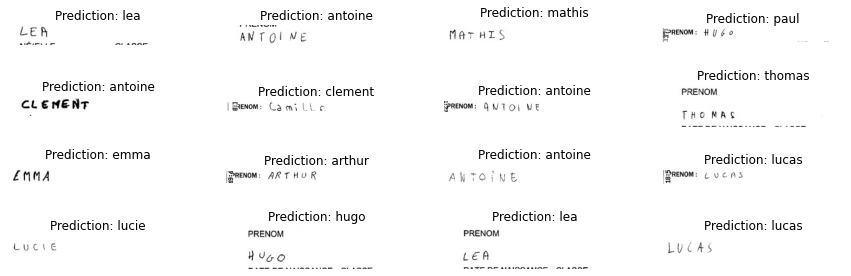

In [59]:
_, ax = plt.subplots(4, 4, figsize=(15, 5))
for i in range(16):
    img_dir = path+test_n_shape.loc[i, 'FILENAME']
    img = cv2.imread(img_dir)
    #img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    title = f"Prediction: {pred_test[i]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
plt.show()